In [12]:
import cv2
import numpy as np
from roipoly import roipoly
import matplotlib.pyplot as plt
import pylab as pl
%matplotlib inline

In [13]:
path_video = 'C:\\Users\\shant\\Underwater_Color_Segmentation_GMM_EM_Algorithm\\data\\detectbuoy.avi'

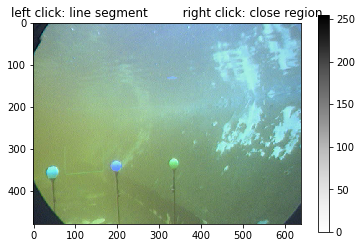

IndexError: list index out of range

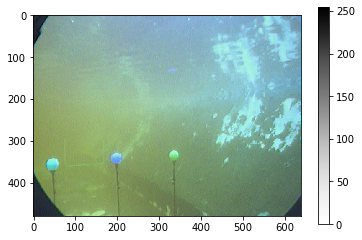

In [11]:
cap = cv2.VideoCapture(path_video)

while(cap.isOpened()):
    
    ret, frame = cap.read()
    
    if(ret):
        
        image1 = frame.copy()
        
        pl.imshow(image1, interpolation = 'nearest', cmap="Greys")
        pl.colorbar()
        pl.title("left click: line segment         right click: close region")
        ROI1 = roipoly(roicolor='r') #let user draw first ROI
        pl.imshow(image1, interpolation = 'nearest', cmap = "Greys")
        pl.colorbar()
        ROI1.displayROI()
        
        # save first buoy image
        points = np.array(ROI1.get_points(image1.copy()))
        (x,y), radius = cv2.minEnclosingCircle(points)
        center = (int(x),int(y))
        radius = int(radius)
        #cv2.circle(image1,center,radius,(0,255,0),2)
        cropped = image1[y:y+h, x:x+w].copy()
        #cv2.imwrite("data/buoy2/buoy" + str(count) + ".png", cropped)
        np.pi()
        count = count + 1
    else:
        break
cap.release()
cv2.destroyAllWindows()